<a href="https://colab.research.google.com/github/unverciftci/GMR/blob/master/GenModReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresion with flows

This notebook shows some first steps using flows for regression.

In [0]:
# Required packages
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

tfd = tfp.distributions
tfb = tfp.bijectors

In [0]:
# Define a sixth-order polynomial 
n = 200
x = np.linspace(-4, 4, n+1, dtype=np.float32)
f = lambda x: -0.001*(x)*(x-4)*(x+4)*(x+3)*(x-3)*(x-1) # -1

# Unnoisy data points
X_unnoisy = f(x)
np.random.seed(1)
# Noisy data points
X = np.array([a +  0.03 * np.random.normal(0,1) for a in X_unnoisy], dtype=np.float32)

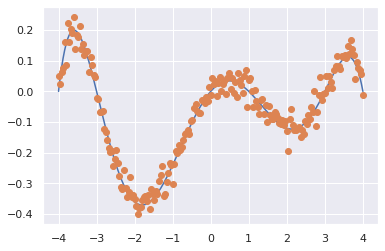

In [0]:
plt.plot(x, f(x))
plt.plot(x, X, 'o')

In [0]:
# Define the normalizing flow

num_bijectors = 30
bs=[]
for i in range(num_bijectors):
    
    shift = tf.Variable(0.0)
    scale=tf.Variable(1.0)
    bs.append(tfb.Shift(shift)(tfb.Scale(scale)))
    
    skewness=tf.Variable(0.0)
    tailweight=tf.Variable(1.0) 
    bs.append(tfb.SinhArcsinh(skewness,tailweight))
    
bijector = tfb.Chain(bs) 
dist = tfd.TransformedDistribution(distribution=
        #tfd.Uniform(low=0.0, high=1.0),bijector=bijector)
        tfd.Normal(loc=0,scale=1),bijector=bijector)

In [0]:
# Estimator of the normalizing constan

logK = 1 # first guess
#logK = tf.sqrt(loss) # guess after initial training 

In [0]:
# Optimization staff

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

@tf.function #Compiles function for fast execution
def train_step(x):
    with tf.GradientTape() as tape:
        loss = tf.keras.losses.MSE(X, -dist.log_prob(x) - logK)
        gradients = tape.gradient(loss,dist.trainable_variables)     
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) 
        return loss

In [0]:
# Training
for i in range(26001):
    loss = train_step(x)
    if (i % 1000 == 0):
      print(i, "Loss ",loss.numpy())

0 Loss  7.669762
1000 Loss  0.014694881
2000 Loss  0.013658559
3000 Loss  0.011754152
4000 Loss  0.008324865
5000 Loss  0.0063967244
6000 Loss  0.005105819
7000 Loss  0.0031330155
8000 Loss  0.0015619592
9000 Loss  0.0012328397
10000 Loss  0.001066753
11000 Loss  0.0010769942
12000 Loss  0.00095121545
13000 Loss  0.0009336664
14000 Loss  0.00089049636
15000 Loss  0.0009713489
16000 Loss  0.0008814118
17000 Loss  0.0008512705
18000 Loss  0.0011538198
19000 Loss  0.0018893024
20000 Loss  0.0008211374
21000 Loss  0.000808113
22000 Loss  0.0007972132
23000 Loss  0.0008652007
24000 Loss  0.0007631569
25000 Loss  0.00074498623
26000 Loss  0.0007347449


In [0]:
# Regressor

f_pred = -dist.log_prob(x) - logK

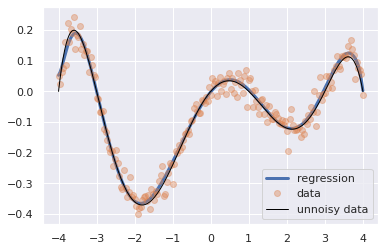

In [0]:
plt.plot(x, f_pred, linewidth=3, label='regression')
plt.plot(x, X, 'o', label='data', alpha=0.4)
plt.plot(x, f(x), 'black',linewidth=1, label='unnoisy data')
plt.legend()

Confidence Interval

Bijection

Text(0, 0.5, 'z')

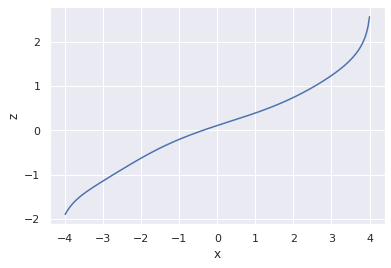

In [0]:
plt.plot(x, bijector.inverse(x))
plt.xlabel('x')
plt.ylabel('z')

Distribution

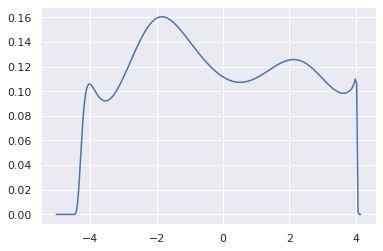

In [0]:
y = np.linspace(-20,20,1000)
P = dist.prob(y)
plt.plot(y, P)

**Credits:** Flow architecture is adopted from the book [Probabilistic Deep Learning](https://tensorchiefs.github.io/dl_book/).